In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Load data
# data_path = './data/' # default sim data from Udacity
# data_path = '../Simulator/' # my sim data
data_path = './training_data/' # AWS sim data
img_path = data_path+'IMG/'
csv_file = data_path+'driving_log.csv'

In [3]:
# read the CSV file into a list
samples = []
with open(csv_file) as f:
    reader = csv.reader(f)
    next(reader) # skip 1st line, in case it's a header line
    for line in reader:
        samples.append(line)

In [5]:
# split out the validation dataset
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [32]:
# exponential offset steering function
# provides more correction when steering is AWAY from camera,
# less when towards camera

def steering_corr(steer):
    k = 1.0
    b = 0.25
#     return k*(np.exp(steer)-1) + b
    return b

In [33]:
#set color space
colorspace = cv2.COLOR_BGR2RGB
# colorspace = cv2.COLOR_RGB2GRAY

In [34]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:

                # center camera
                name = img_path+batch_sample[0].split('/')[-1]
                center_image = cv2.cvtColor(cv2.imread(name), colorspace)#[...,np.newaxis]
                center_angle = float(batch_sample[3])

                # left camera
                name = img_path+batch_sample[1].split('/')[-1]
                left_image = cv2.cvtColor(cv2.imread(name), colorspace)#[...,np.newaxis]
                left_angle = center_angle + steering_corr(center_angle)
                left_angle = min(max(left_angle, -1.0), 1.0)

                # right camera
                name = img_path+batch_sample[2].split('/')[-1]
                right_image = cv2.cvtColor(cv2.imread(name), colorspace)#[...,np.newaxis]
                right_angle = center_angle - steering_corr(-center_angle)
                right_angle = min(max(right_angle, -1.0), 1.0)

                # append data from all 3 cameras
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
                
            X_train_orig = np.array(images)
            y_train_orig = np.array(angles)
            
            # create flipped image data as well
            X_train_flip = np.array(np.fliplr(images))
            y_train_flip =-np.array(angles)
            
            X_train = np.concatenate((X_train_orig, X_train_flip), axis=0)
            y_train = np.concatenate((y_train_orig, y_train_flip), axis=0)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [35]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

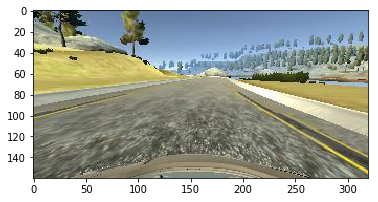

In [36]:
# determine the input image shape
# by looking at 1st frame's center image
image0 = cv2.cvtColor(cv2.imread(img_path+train_samples[0][0].split('/')[-1]), colorspace)

plt.imshow(image0)
plt.show()

In [37]:
image1 = image0#[...,np.newaxis]
# plt.imshow(image1)
# plt.show()
print(image1.shape)
imshape = image1.shape

(160, 320, 3)


In [38]:
# train model  
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D

model = Sequential()
model.add(Lambda(lambda x: ((x/255.0)-0.5),
                 input_shape=imshape,
                 name='lambda'))
model.add(Cropping2D(cropping=((50,20),(0,0)),
                     name='crop'))
model.add(Conv2D(nb_filter=24,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv1'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nb_filter=36,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv2'))
model.add(Conv2D(nb_filter=48,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv3'))
model.add(Conv2D(nb_filter=64,
                 nb_row=3,
                 nb_col=3,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='elu',
                 name='conv4'))
model.add(Conv2D(nb_filter=64,
                 nb_row=3,
                 nb_col=3,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='elu',
                 name='conv5'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten(name='flat'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(100, activation='elu', name='dense1'))
model.add(Dense(50, activation='elu', name='dense2'))
model.add(Dense(10, activation='elu', name='dense3'))
model.add(Dense(1, name='output'))

In [39]:
from functools import reduce
def prod(input):
    return reduce(lambda x, y: x*y, input, 1)

print('Layer input shapes:')
for layer in model.layers:
    shape = layer.get_input_shape_at(0)
    print(layer.name, shape, ' = '+str(prod(shape[1:]))+' neurons', sep='\t')

Layer input shapes:
lambda	(None, 160, 320, 3)	 = 153600 neurons
crop	(None, 160, 320, 3)	 = 153600 neurons
conv1	(None, 90, 320, 3)	 = 86400 neurons
conv2	(None, 43, 158, 24)	 = 163056 neurons
conv3	(None, 20, 77, 36)	 = 55440 neurons
conv4	(None, 8, 37, 48)	 = 14208 neurons
conv5	(None, 6, 35, 64)	 = 13440 neurons
flat	(None, 4, 33, 64)	 = 8448 neurons
dropout	(None, 8448)	 = 8448 neurons
dense1	(None, 8448)	 = 8448 neurons
dense2	(None, 100)	 = 100 neurons
dense3	(None, 50)	 = 50 neurons
output	(None, 10)	 = 10 neurons


In [40]:
# model compilation
model.compile(loss='mse',
              optimizer='adam')

In [41]:
# setting up Model checkpoint callback
from keras.callbacks import ModelCheckpoint

save_filename = 'model.h5'
checkpoint = ModelCheckpoint(save_filename,
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False)
callbacks_list = [checkpoint]

In [42]:
# history_obj = model.fit(X_train, y_train,
#                         validation_split=0.2,
#                         shuffle=True,
#                         nb_epoch=3,
#                         batch_size=64)

history_obj =  model.fit_generator(train_generator,
                                   samples_per_epoch=len(train_samples)*6,
                                   validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples)*6,
                                   nb_epoch=6,
                                   callbacks=callbacks_list)

# model.save('model.h5')

Epoch 1/6
21474/21474 [==============================] - 53s - loss: 0.0586 - val_loss: 0.0128

In [43]:
### print the keys contained in the history object
print('History object keys:')
print(history_obj.history.keys())

History object keys:
dict_keys(['loss', 'val_loss'])


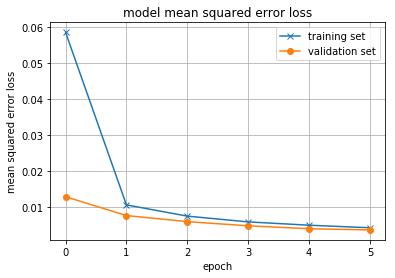

In [44]:
### plot the training and validation loss for each epoch
plt.plot(history_obj.history['loss'],'x-')
plt.plot(history_obj.history['val_loss'],'o-')
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid()
plt.show()

In [45]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda (Lambda)                  (None, 160, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
crop (Cropping2D)                (None, 90, 320, 3)    0           lambda[0][0]                     
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 43, 158, 24)   1824        crop[0][0]                       
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 20, 77, 36)    21636       conv1[0][0]                      
___________________________________________________________________________________________

In [46]:
from keras import __version__ as ver
print(ver)

1.2.1


In [48]:
from tensorflow import __version__ as tf_ver
print(tf_ver)

0.12.1


In [49]:
cv2.__version__

'3.1.0'